### Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pennylane import numpy as np
from pennylane.templates import BasicEntanglerLayers,StronglyEntanglingLayers,RandomLayers
from pennylane import broadcast
import h5py
import pennylane as qml
import deap
import random
import time
import multiprocessing as mp
import itertools
from itertools import combinations
qml.__version__

'0.24.0'

In [53]:
n_qubits = 4
dev_wires = [np.array(idx, requires_grad=True) for idx in range(n_qubits)]
dev = qml.device('qulacs.simulator', wires=dev_wires, gpu=True, shots=10000)
num_bins = 16

### keys represent gates, values represent number of parameters required
two_qubits_gates_with_params = {qml.CNOT:0}
one_qubit_gates_with_params = {qml.RX:1, qml.RY:1, qml.RZ:1}
two_qubits_gates = list(two_qubits_gates_with_params.keys())
one_qubit_gates = list(one_qubit_gates_with_params.keys())


In [54]:
def get_num_params(tensor, n_qubits, num_one_gates, num_two_gates):
    num_params = 0
    total_gates = num_one_gates + num_two_gates
    for moment in tensor:
        for q_idx in range(n_qubits):
            curr_qubit = moment[q_idx]
            for gate_idx in range(0, total_gates):
                if not curr_qubit[gate_idx]:
                    if gate_idx <= num_one_gates:
                        gate = one_qubit_gates[gate_idx]
                        curr_num_params = one_qubit_gates_with_params[gate]
                        num_params += curr_num_params
                    else:
                        gate = two_qubits_gates[gate_idx - num_one_gates]
                        target_idx = curr_qubit[gate_idx] - 1
                        curr_num_params = two_qubits_gates_with_params[gate]
                        num_params += curr_num_params
                    break
    return num_params

In [55]:
def generate_random_tensor(n_qubits, num_one_gates, num_two_gates, max_moments):
    tensor = []
    total_gates = num_one_gates + num_two_gates * 2
    num_moments = random.randint(1,max_moments)
    for m in range(num_moments):
        moment = []
        for q in range(n_qubits):
            curr_qubit = [0] * total_gates
            moment.append(curr_qubit)
        qubit_options = list(range(n_qubits))
        gates_options = list(range(total_gates))
        while not len(qubit_options) == 0:
            rand_gates_idx = random.choice(gates_options)
            if rand_gates_idx < num_one_gates:
                rand_qubit_idx = random.choice(qubit_options)
                moment[rand_qubit_idx][rand_gates_idx] = 1
                qubit_options.remove(rand_qubit_idx)
            else:
                if len(qubit_options) >= 2:
                    rand_control, rand_target = random.sample(qubit_options, k = 2)
                    qubits_used = [rand_control, rand_target]
                    # qubits_used = list(range(min(rand_target, rand_control), max(rand_target, rand_control)))
                    if all(x in qubit_options for x in qubits_used):
                        if (rand_gates_idx - num_one_gates) % 2 == 0:
                            moment[rand_control][rand_gates_idx] = rand_target + 1
                            moment[rand_target][rand_gates_idx + 1] = rand_control + 1
                        else:
                            moment[rand_control][rand_gates_idx -1] = rand_target + 1
                            moment[rand_target][rand_gates_idx] = rand_control + 1
                        qubit_options = [ q for q in qubit_options if not q in qubits_used]
                    else:
                        qubit_options.append(rand_control)
        tensor.append(moment)
    return tensor


In [56]:
@qml.qnode(dev)
def convert_tensor_to_circuit(tensor, params, n_qubits, num_one_gates, num_two_gates, prob=True):
    total_gates = num_one_gates + num_two_gates*2
    params_idx = 0
    for moment in tensor:
        for q_idx in range(n_qubits):
            curr_qubit = moment[q_idx]
            for gate_idx in range(total_gates):
                if not curr_qubit[gate_idx] == 0:
                    if gate_idx < num_one_gates:
                        gate = one_qubit_gates[gate_idx]
                        curr_num_params = one_qubit_gates_with_params[gate]
                        if curr_num_params == 0:
                            gate(wires=dev_wires[q_idx])
                        else:
                            broadcast(unitary=gate, pattern="single", wires=dev_wires[q_idx], parameters=params[params_idx:params_idx+curr_num_params])
                            params_idx += curr_num_params
                    else:
                        if (gate_idx - num_one_gates) % 2 == 0:
                            gate = two_qubits_gates[gate_idx - num_one_gates]
                            target_idx = curr_qubit[gate_idx] -1
                            curr_num_params = two_qubits_gates_with_params[gate]
                            if curr_num_params == 0:
                                gate(wires=[dev_wires[q_idx], dev_wires[target_idx]])
                            else:
                                broadcast(unitary=gate, pattern="double", wires=[dev_wires[q_idx], dev_wires[target_idx]], parameters=params[params_idx:params_idx+curr_num_params])
                                params_idx += curr_num_params
                    break
    
    if prob:
        return qml.probs(wires=dev_wires[0:n_qubits])
    else:
        return qml.sample(wires=dev_wires[0:n_qubits])

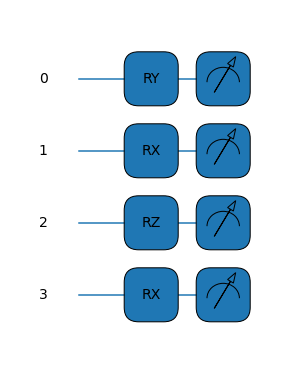

In [57]:
tensor = [[[0, 1, 0, 0, 0], 
           [1, 0, 0, 0, 0], 
           [0, 0, 1, 0, 0], 
           [1, 0, 0, 0, 0],
           [0, 0, 0, 0, 0], 
           [1, 0, 0, 0, 0], 
           [0, 1, 0, 0, 0], 
           [0, 1, 0, 0, 0]]]

num_params = get_num_params(tensor, n_qubits, 3, 1)
init_params = (2.*np.pi)*np.random.random(num_params)


convert_tensor_to_circuit(tensor, init_params, n_qubits, 3, 1)
fig, ax = qml.draw_mpl(convert_tensor_to_circuit)(tensor, init_params, n_qubits, 3, 1)
fig.savefig('tensor_rep.png', bbox_inches='tight')
fig.show()

### Classes

In [58]:
### Loss Functions

def qml_entropy(pk,qk):
    '''
    do not use scipy implementatin of entropy, will use different numpy versions
    this uses the pennylane wrapped version of numpy
    '''
    qk = np.asarray(qk)
    ck = np.broadcast(pk, qk)

    vec = [u*np.log(u/v) if (u>0 and v>0) else 0 if (u == 0 and v>=0) else np.inf for (u,v) in ck]
    S = np.sum(vec)
    return S

def hybrid_jensen_shannon_loss(pk,qk):
    ''' this is a temporary function while we debug the layerwise training'''
    p = target
    q = hybrid_pdf(params,fixed_params=fixed_params)
    M = np.multiply(q+p,0.5)

    return 0.5*qml_entropy(p,M)+0.5*qml_entropy(q,M)

def jensen_shannon_loss(p,q):
    M = np.multiply(q+p,0.5)
    return 0.5*qml_entropy(p,M)+0.5*qml_entropy(q,M)


### Stop conditions

def scheduled_stepsize(iteration):
    min_step= 0.000001
    max_step = 0.01
    ss = min_step+(max_step - min_step)*np.abs(np.cos(np.pi/10.*iteration))
    print('step size set to {}'.format(ss))
    return ss

def scheduled_opt(self,iteration, opt_method):
    return opt_method(stepsize=scheduled_stepsize(iteration))


def early_stopping(loss_values ,  patience=1, draw=False):
    #check whether the loss is plateauing
    if len(loss_values) < 2*patience:
        #not enough values to think about
        return False

    ref_value = np.min(loss_values[-2*patience:-patience])
    last_value = np.min( loss_values[-patience:])
    return (last_value >= ref_value)


def adaptLR(losses, opt):
    last_N = 10
    factor = 2
    if len(losses)<last_N: return False
    # if len(losses)-adaptLR.lastchange< last_N: return False
    max_consecutive_downards = np.max([ sum( 1 for _ in group ) for key, group in itertools.groupby( np.diff( losses[-last_N:]) <0  ) if key ])
    roughness = 1.-max_consecutive_downards / float(last_N-1)
    #print(f"Loss roughness: {roughness}")
    if roughness > 0.5:
        # adaptLR.lastchange = len(losses)
        old_LR = np.asarray(opt.stepsize)
        opt.stepsize = old_LR/ factor
        print(f"Reducing LR :{old_LR} \u2192 {np.asarray(opt.stepsize)}")
        plt.figure(figsize=(10,3))
        plt.plot(losses[-last_N:])
        ymin,ymax = plt.ylim()
        offset = 0.1* (ymax-ymin)
        plt.xlabel('last iterations')
        plt.ylabel('training loss')
        plt.show()
        return True

In [69]:
class IndividualCircuit:
    
    def __init__(self, tensor, target, num_one_gates, num_two_gates, n_qubits, n_steps=None, scheduled=False):
        self.tensor = tensor
        self.params = (2.*np.pi)*np.random.random(get_num_params(tensor, n_qubits, num_one_gates, num_two_gates))
        self.num_one_gates = num_one_gates
        self.num_two_gates = num_two_gates
        self.fitness = 0.0
        self.losses = []
        self.fitnesses = []
        self.n_qubits = n_qubits
        self.best_loss_idx = 0
        self.target = target
        self.LR = []
        
    def train(self, circuit, n_steps=None, scheduled=False):
        trained_params = self.params.copy()
        start = time.mktime(time.gmtime())
        stop = start
        i_steps = 0
        init_stepsize = 0.01
        opt = qml.AdamOptimizer(stepsize=init_stepsize)
        # self.LR.append(init_stepsize)
        best_params = trained_params
        while True:
            # update the circuit parameters in each iteration
            prelap = time.mktime(time.gmtime())
            iteration = len(self.losses)
            # print('starting iteration {}'.format(len(self.losses)+1))
            if scheduled: 
                opt=scheduled_opt(len(self.losses))
            trained_params, L = opt.step_and_cost(lambda v: self.loss_1d(circuit,v), trained_params)
            lap = start = time.mktime(time.gmtime())
            step_time = lap - prelap
            stop+=step_time
            # L = loss(trained_params) 
            self.losses.append( L )
            
            # if adaptLR(self.losses, opt):
            #     self.LR.append(opt.stepsize)
                
            
            # update the stop conditions
            early_stop  = early_stopping( self.losses, patience=20)
            i_steps+=1
            i_stop = (n_steps!=None) and (i_steps>=n_steps)
            stop = early_stop or i_stop
            
            # keep track of the min loss and corresponding params
            curr_min_idx = np.where(self.losses == np.min(self.losses))[0][-1]
            self.best_loss_idx = curr_min_idx
            if curr_min_idx == iteration - 1: 
                self.best_loss_idx = curr_min_idx
                self.params = trained_params
                
            if stop: break
        
        self.fitnesses = [1 - x for x in self.losses]
        
        
    def adaptLR(self, opt):
        last_N = 30
        factor = 1.5
        if len(self.losses)<last_N: return False
        if len(self.losses)-self.last_LR_change< last_N: return False
        max_consecutive_downards = np.max([ sum( 1 for _ in group ) for key, group in itertools.groupby( np.diff( self.losses[-last_N:]) <0  ) if key ])
        roughness = 1.-max_consecutive_downards / float(last_N-1)
        print(f"Loss roughness: {roughness}")
        if roughness > 0.5:
            self.last_LR_change = len(losses)
            old_LR = np.asarray(opt.stepsize)
            opt.stepsize = old_LR/ factor
            print(f"Reducing LR :{old_LR} \u2192 {np.asarray(opt.stepsize)}")
            plt.figure(figsize=(10,3))
            plt.plot(losses[-last_N:])
            ymin,ymax = plt.ylim()
            offset = 0.1* (ymax-ymin)
            plt.xlabel('last iterations')
            plt.ylabel('training loss')
            plt.show()
            return True


    def train_fitness(self, n_steps=None, scheduled=False):
        # start_time = time.time()
        self.train(convert_tensor_to_circuit, n_steps, scheduled)
        self.fitness = self.fitnesses[self.best_loss_idx]
        # end_time = time.time()
        # exec_time = end_time - start_time
        # print("Execution time multiprocessing {}".format(exec_time))
    
    def get_fitness(self):
        return self.fitness
    
    
    def draw(self, title=""):
        fig, ax = qml.draw_mpl(convert_tensor_to_circuit)(self.tensor, self.params, self.n_qubits, self.num_one_gates, self.num_two_gates)
        ax.set_title(title)
        fig.show()
    
    def plot_fitness(self, title="fitnesses"):
        plt.title(title)
        plt.plot(self.fitnesses)
        plt.xlabel('iterations')
        plt.ylabel('fitness')
        plt.scatter(self.best_loss_idx, self.fitnesses[self.best_loss_idx],c='r')
        plt.show()
    
    def plot_loss(self, title="losses"):
        plt.title(title)
        plt.plot(self.losses)
        plt.xlabel('iterations')
        plt.ylabel('training loss')
        plt.scatter(self.best_loss_idx, self.losses[self.best_loss_idx],c='r')
        plt.show()
    
    def update_params(self):
        print("updating params...")
        self.params = (2.*np.pi)*np.random.random(get_num_params(self.tensor, self.n_qubits, self.num_one_gates, self.num_two_gates))
    
    # def plot_loss_and_draw(self, loss_title = "losses", circuit_title="", file_name =""):
    #     plt.figure(figsize=(12,5))
    #     plt.title(loss_title)
    #     plt.plot(self.losses)
    #     plt.xlabel('iterations')
    #     plt.ylabel('training loss')
    #     plt.scatter(self.best_loss_idx, self.losses[self.best_loss_idx],c='r')
    #     fig, ax = qml.draw_mpl(convert_tensor_to_circuit)(self.tensor, self.params, self.n_qubits, self.num_one_gates, self.num_two_gates)
    #     ax.set_title(circuit_title)
    #     if not file_name == "":
    #         plt.savefig(file_name, bbox_inches='tight')
    #     else:
    #         plt.show()
        
        
    def get_tensor(self):
        return self.tensor        
        
    def loss_1d(self, circuit, params):
        return jensen_shannon_loss(circuit(self.tensor, params, self.n_qubits, self.num_one_gates, self.num_two_gates), self.target)
    
    def loss_2d(self, circuit, params):
        return jensen_shannon_loss(circuit(self.tensor, params, self.n_qubits, self.num_one_gates, self.num_two_gates).reshape(16,16),self.target.reshape(16,16))

### Data Reading 

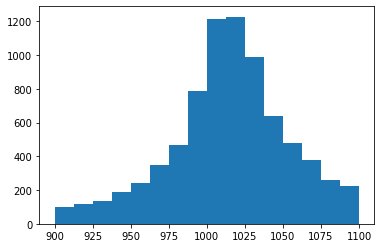

In [70]:
jet_filename = '../jetImage_0_30p_0_10000.h5'
f1 = h5py.File(jet_filename,'r')
jets = np.array(f1["jets"])
j_pt = jets[:, 1]
j_mass = jets[:, 3]
num_bins = 16
min_pt = 900
max_pt = 1100
distribution_pt, bins_pt_edge, __ = plt.hist(j_pt, range=[min_pt, max_pt], bins=num_bins)
probability_pt = distribution_pt / np.sum(distribution_pt)
bins_pt = np.asarray([(bins_pt_edge[i] + bins_pt_edge[i+1])/2. for i in range(len(bins_pt_edge)-1)])

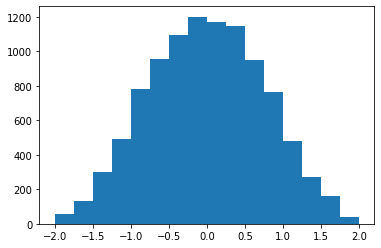

In [71]:
j_eta = jets[:, 2]
min_eta = -2
max_eta = 2
distribution_eta, bins_eta_edge, __ =plt.hist(j_eta, range=[min_eta, max_eta], bins=num_bins)
probability_eta = distribution_eta / np.sum(distribution_eta)
bins_eta = np.asarray([(bins_eta_edge[i] + bins_eta_edge[i+1])/2. for i in range(len(bins_eta_edge)-1)])

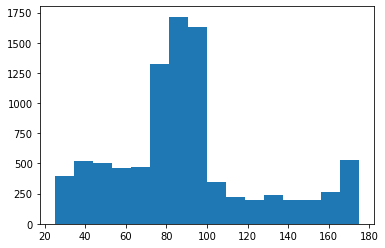

In [72]:
min_mass = 25
max_mass = 175
distribution_mass, bins_mass_edge, __ =plt.hist(j_mass, range=[min_mass, max_mass],bins=num_bins)
probability_mass = distribution_mass / np.sum(distribution_mass)
bins_mass = np.asarray([(bins_mass_edge[i] + bins_mass_edge[i+1])/2. for i in range(len(bins_mass_edge)-1)])

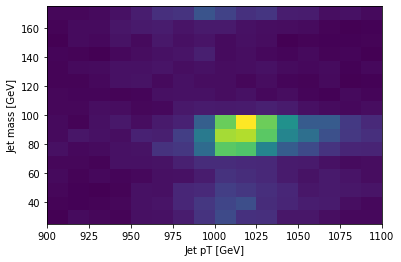

In [73]:
# plt.figure(figsize=(12,5))
# plt.subplot(121)
# target_2d, bins_pt_edge, bins_eta_edge, _ = plt.hist2d(j_pt, j_eta, bins=[16,16], range=[[min_pt, max_pt],[min_eta, max_eta]])
# plt.suptitle("Target")
# plt.xlabel('Jet pT [GeV]')
# plt.ylabel('Jet eta')
# bins_pt = np.asarray([(bins_pt_edge[i] + bins_pt_edge[i+1])/2. for i in range(len(bins_pt_edge)-1)])
# bins_eta = np.asarray([(bins_eta_edge[i] + bins_eta_edge[i+1])/2. for i in range(len(bins_eta_edge)-1)])
# bins_pt_eta=list(itertools.product(bins_pt,bins_eta))
# plt.subplot(122)
target_2d, bins_pt_edge, bins_mass_edge, _ = plt.hist2d(j_pt, j_mass, bins=[16,16], range=[[min_pt, max_pt],[min_mass, max_mass]])
plt.xlabel('Jet pT [GeV]')
plt.ylabel('Jet mass [GeV]')
plt.show()
bins_pt = np.asarray([(bins_pt_edge[i] + bins_pt_edge[i+1])/2. for i in range(len(bins_pt_edge)-1)])
bins_mass = np.asarray([(bins_mass_edge[i] + bins_mass_edge[i+1])/2. for i in range(len(bins_mass_edge)-1)])
bins_pt_mass=list(itertools.product(bins_pt,bins_mass))
plt.savefig('../target_data/target_2D.png', bbox_inches='tight')
plt.close("all")
# plt.show()

In [74]:
target_2d

array([[  2.,   4.,   6.,   9.,   6.,  13.,   9.,   9.,   6.,   6.,   4.,
          4.,   5.,   1.,   4.,   6.],
       [ 10.,   3.,   3.,   4.,   6.,   8.,  18.,   4.,   6.,   5.,   4.,
          9.,   4.,  10.,  10.,   6.],
       [  6.,   4.,   2.,   8.,   4.,  10.,  14.,  13.,  12.,   5.,   7.,
         10.,   2.,   8.,  10.,   9.],
       [  4.,   6.,   4.,   5.,  14.,  14.,  12.,  20.,  11.,   4.,  14.,
         14.,   8.,  16.,  18.,  15.],
       [ 13.,  14.,  15.,   8.,  15.,  16.,  29.,  11.,   6.,   5.,  16.,
         14.,  11.,   9.,  21.,  25.],
       [ 15.,  17.,  13.,  13.,  16.,  44.,  26.,  21.,   8.,  13.,   9.,
         17.,  14.,  20.,  24.,  42.],
       [ 24.,  33.,  33.,  15.,  27.,  48.,  56.,  28.,  20.,  14.,  14.,
         12.,  17.,  13.,  17.,  45.],
       [ 45.,  49.,  36.,  24.,  38., 105., 123.,  91.,  23.,  14.,  11.,
         14.,  26.,  17.,  22.,  79.],
       [ 68.,  62.,  55.,  44.,  38., 224., 260., 233.,  21.,  11.,  11.,
         11.,  10.,  1

In [75]:
target_2d = target_2d / np.sum(target_2d)
target_1d = np.ravel(target_2d)

In [76]:
max_moments = 2
num_one_gates = 3
num_two_gates = 1

In [93]:
rand_tensor = generate_random_tensor(n_qubits, num_one_gates, num_two_gates, max_moments)

tensor = [[[0, 0, 1, 0, 0], [0, 0, 0, 4, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 2]],
 [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0]],
 [[0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0], [0, 0, 0, 3, 0], [0, 0, 0, 0, 2], [0, 0, 1, 0, 0]]]



circuit = IndividualCircuit(tensor, probability_pt, num_one_gates, num_two_gates,n_qubits)

In [94]:
circuit.train_fitness()

In [95]:
circuit.get_fitness()

tensor(0.96136901, requires_grad=True)

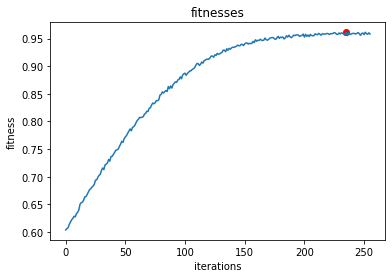

In [96]:
circuit.plot_fitness()

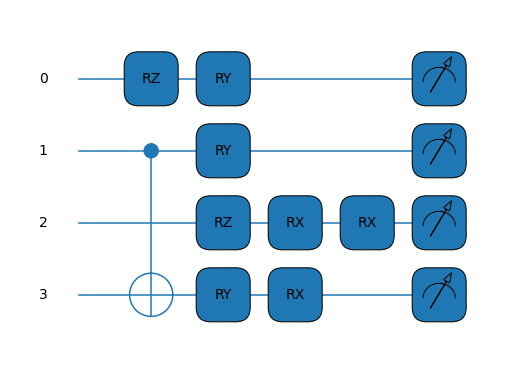

In [83]:
circuit.draw()

In [94]:
circuit.tensor

[[[0, 0, 1, 0, 0],
  [1, 0, 0, 0, 0],
  [0, 0, 1, 0, 0],
  [0, 0, 1, 0, 0],
  [0, 0, 1, 0, 0],
  [0, 1, 0, 0, 0],
  [1, 0, 0, 0, 0],
  [0, 0, 1, 0, 0]],
 [[0, 1, 0, 0, 0],
  [0, 0, 1, 0, 0],
  [0, 1, 0, 0, 0],
  [0, 0, 0, 5, 0],
  [0, 0, 0, 0, 4],
  [0, 1, 0, 0, 0],
  [0, 1, 0, 0, 0],
  [0, 1, 0, 0, 0]]]

In [89]:
circuit2 = IndividualCircuit(circuit.tensor, probability_pt, num_one_gates, num_two_gates,n_qubits , 2)

In [90]:
circuit2.tensor

[[[0, 0, 1, 0, 0], [0, 0, 0, 4, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 2]],
 [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0]],
 [[0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]

In [91]:
circuit2.train_fitness()

In [92]:
circuit2.get_fitness()

tensor(0.96205803, requires_grad=True)

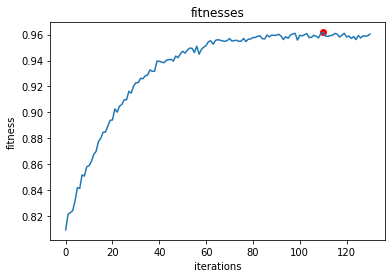

In [88]:
circuit2.plot_fitness()

### Processing 

In [12]:
circuit = IndividualCircuit(tensor, probability_pt, 3, 1, 4, 1)

NameError: name 'tensor' is not defined

In [55]:
circuit.train_fitness()

In [39]:
circuit.get_fitness()

tensor(0.93969634, requires_grad=True)

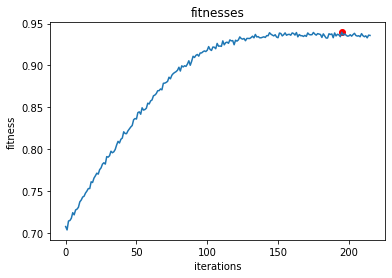

In [40]:
circuit.plot_fitness()

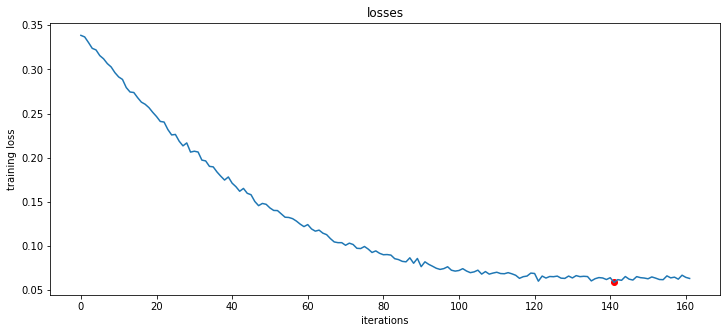

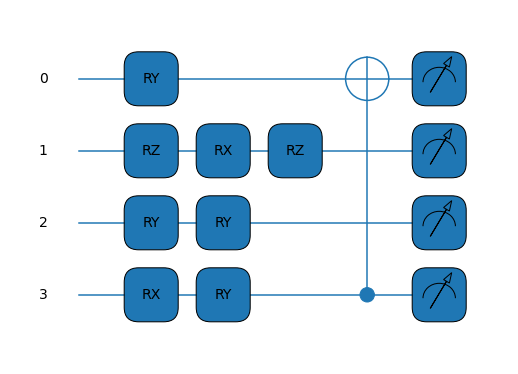

In [56]:
circuit.plot_loss_and_draw(file_name = "../optimizer_data/test.png")

### Classes

In [18]:
class Population:
    def __init__(self):
        self.pop_size = 0
        self.individuals = []
        self.fittest = None
        self.least_fittest = None
    
    def fill_population(self, pop_size, target, num_one_gates, num_two_gates, max_moments, n_qubits):
               
        for i in range(pop_size):
            unique = True
            random_tensor = generate_random_tensor(n_qubits, num_one_gates, num_two_gates, max_moments)
            for j in range(self.pop_size):
                if random_tensor == self.individuals[j].tensor:
                    unique = False
                    break
            if unique:
                curr_circuit = IndividualCircuit(random_tensor, target, num_one_gates, num_two_gates, n_qubits)
                self.pop_size += 1
                self.individuals.append(curr_circuit)
            else:
                i -= 1
        self.update()
    
    
    def add_circuit(self, circuit, increase_size=True):
        self.individuals.append(circuit)
        if increase_size:
            self.pop_size += 1
        self.update()
    
    def add_circuits(self, circuits, increase_size=True):
        self.individuals.extend(circuits.individuals)
        if increase_size:
            self.pop_size += len(circuits)
        self.update()
    
    def get_fittest_fitness(self):
        return self.fittest.get_fitness()
    
    def remove_circuit(self, circuit):
        self.individuals.remove(circuit)
        self.pop_size -= 1
        self.update()
        
        
    def update(self):
        self.individuals.sort(key=lambda circuit:circuit.fitness, reverse=True)
        self.fittest = self.individuals[0]
        self.least_fittest = self.individuals[-1]
        self.pop_size = len(self.individuals)
        
    
    def train_all(self):
        start_time = time.time()
        procs = []
        for circuit in self.individuals:
            proc = mp.Process(target=circuit.train_fitness())
            procs.append(proc)
            proc.start()
        
        for proc in procs:
            proc.join()
        
        end_time = time.time()
        exec_time = end_time - start_time
        print("Execution time multiprocessing {}".format(exec_time))
        self.update()
        
    def train_linear(self):
        start_time = time.time()
        for circuit in self.individuals:
            circuit.train_fitness()
        end_time = time.time()
        exec_time = end_time - start_time
        print("Execution time linear {}".format(exec_time))
        
    
    
    def get_fittests(self, num_fittests):
        self.fittest = self.individuals[0]
        return self.individuals[:num_fittests]     
        

In [24]:
class CircuitOptimizer:
    
    def __init__(self, pop_size, target, num_one_gates, num_two_gates, max_moments, n_qubits):
        self.population = Population()
        self.population.fill_population(pop_size, target, num_one_gates, num_two_gates, max_moments, n_qubits)
        self.generation = 0
        self.pop_size = pop_size
        self.num_one_gates = num_one_gates
        self.num_two_gates = num_two_gates
        self.parents = []
        parents_size = int(pop_size * 0.25)
        if parents_size < 2:
            self.parents_size = 2
        else:
            self.parents_size = parents_size
        self.offsprings = Population()
        self.target = target
        self.n_qubits = n_qubits
        self.population.train_all()
        self.print_info()
    
    def draw_all_circuits(self):
        self.print_info()
        for i in range(len(self.population.individuals)):
            title = "circuit " + str(i+1) + " generation " + str(self.generation) + " fitness: " + str(self.population.individuals[i].get_fitness())
            self.population.individuals[i].draw(title)
    
    
    def draw_offsprings(self):
        for i in range(len(self.offsprings.individuals)):
            title = "offspring " + str(i+1) + " generation " + str(self.generation) + " fitness: " + str(self.offsprings.individuals[i].get_fitness())
            self.offsprings.individuals[i].draw(title)
    
            
    def train_offsprings(self):
        self.offsprings.train_all()
            
    def add_offsprings(self):
        for offspring in self.offsprings.individuals:
            compare = len(offspring.params) == get_num_params(tensor, n_qubits, num_one_gates, num_two_gates)
            if not compare:
                print(offspring.tensor)

                offspring.draw()
        self.population.add_circuits(self.offsprings, increase_size=False)
        self.population.individuals = self.population.individuals[:-len(self.offsprings.individuals)]
        self.offsprings = Population()
        
    
    def print_info(self):
        self.population.update()
        print("Generation: {} Fittest: {}".format(self.generation, self.population.fittest.get_fitness()))
        
    
    # choose the two most fit
    def selection(self):
        self.parents = self.population.get_fittests(self.parents_size)
            
        
    
    # choose a random moment as the crossover point, then swap the rest of the moments
    def crossover(self):
        for i in range(0, len(self.parents)-1, 2):
            parent1 = self.parents[i]
            parent2 = self.parents[i+1]
            self.crossover_pair(parent1, parent2)
        if len(self.parents) % 2 == 1:
            parent1 = self.parents[-1]
            parent2 = random.choice(self.parents[:len(self.parents)-1])
            self.crossover_pair(parent1, parent2)
        
            
    
    def crossover_pair(self, parent1, parent2):
        if len(parent1.tensor) == 1:
            cross_pt1 = random.randint(1, len(parent1.tensor))
            tensor1 = parent1.get_tensor()
            if len(parent2.tensor) == 1:
                cross_pt2 = random.randint(1, len(parent2.tensor))
                tensor2 = parent2.get_tensor()
            else:
                cross_pt2 = random.randint(1, len(parent2.tensor)-1)
                tensor2 = parent2.get_tensor()[:cross_pt2]
                tensor1 += parent2.get_tensor()[:cross_pt2]
        elif len(parent2.tensor) == 1:
            cross_pt2 = random.randint(1, len(parent2.tensor))
            tensor2 = parent2.get_tensor()
            cross_pt1 = random.randint(1, len(parent1.tensor)-1)
            tensor1 = parent1.get_tensor()[:cross_pt1]
            tensor2 += parent1.get_tensor()[:cross_pt1]
        else:
            cross_pt1 = random.randint(1, len(parent1.tensor)-1)
            cross_pt2 = random.randint(1, len(parent2.tensor)-1)
            tensor1 = parent1.get_tensor()[:cross_pt1] + parent2.get_tensor()[cross_pt2:]
            tensor2 = parent2.get_tensor()[:cross_pt2] + parent1.get_tensor()[cross_pt1:]
            
        
        
        
        params1 = (2.*np.pi)*np.random.random(get_num_params(tensor1, self.n_qubits, self.num_one_gates, self.num_two_gates))
        params2 = (2.*np.pi)*np.random.random(get_num_params(tensor2, self.n_qubits, self.num_one_gates, self.num_two_gates))
        
        self.offsprings.add_circuit(IndividualCircuit(tensor1, self.target, self.num_one_gates, self.num_two_gates, self.n_qubits))
        self.offsprings.add_circuit(IndividualCircuit(tensor2, self.target, self.num_one_gates, self.num_two_gates, self.n_qubits))
    
        
    
    
    
    
    # choose a random point to switch on/off the gate; for two qubit gates, the target gate is changed to a random value
    def mutate(self):
        # identical_circuits = 0
        for i in range(len(self.offsprings.individuals)):
            
            curr_offspring = self.offsprings.individuals[i]
            mutate_gate = random.randint(0, self.num_one_gates-1)
            mutate_moment = random.randint(0, len(curr_offspring.tensor)-1)
            qubits_options = []
            curr_moment = curr_offspring.tensor[mutate_moment]

            ## mutate one qubit gate
            if random.randint(0, 1):
                
                for q in range(len(curr_moment)):
                    curr_qubit = curr_moment[q]
                    if not any(curr_qubit[self.num_one_gates:]):
                        qubits_options.append(q)
                
                
                if len(qubits_options) == 0:
                    i -= 1
                    continue
                
                
                mutate_qubit = random.choice(qubits_options)
                qubits_options.remove(mutate_qubit)  
                
                
                q = curr_offspring.tensor[mutate_moment][mutate_qubit]
                q[mutate_gate] = curr_offspring.tensor[mutate_moment][mutate_qubit][mutate_gate] ^ 1
                for i in range(self.num_one_gates + self.num_two_gates):
                    if q[i] and not i == mutate_gate:
                        q[i] = 0
                                
                
                
                
            # mutate two qubit gate
            else:
                two_gates_idx = self.num_one_gates + random.randrange(0, self.num_two_gates*2, 2)
                
                for q in range(len(curr_moment)):
                    curr_qubit = curr_moment[q]                        
                    if not any(curr_qubit[:two_gates_idx]):
                        if two_gates_idx + 2 < len(curr_qubit):
                            if not any(curr_qubit[two_gates_idx+2:]):
                                qubits_options.append(q)
                        else:
                            qubits_options.append(q)
                
                if len(qubits_options) <= 1:
                    i -= 1
                    continue
                
                mutate_qubit = random.choice(qubits_options)
                qubits_options.remove(mutate_qubit)  
                
                no_gates_qubits = []
                for qubit in qubits_options:
                    if not any(curr_moment[qubit]):
                        no_gates_qubits.append(qubit)
                
                if not curr_moment[mutate_qubit][two_gates_idx] == 0:
                    choice = random.randint(0,2)
                    if choice == 0:
                        self.swap(qubits_options, curr_moment, mutate_qubit, two_gates_idx)
                    elif choice == 1:
                        self.turn_off(qubits_options, curr_moment, mutate_qubit, two_gates_idx) 
                    else:
                        if len(no_gates_qubits) == 0:
                            i -= 1
                            continue
                        self.mutate_one(no_gates_qubits, curr_moment, mutate_qubit, two_gates_idx)
                        
                elif not curr_moment[mutate_qubit][two_gates_idx+1] == 0:
                    choice = random.randint(0,2)
                    if choice == 0:
                        self.swap(qubits_options, curr_moment, mutate_qubit, two_gates_idx+1, target=True)
                    elif choice == 1:
                        self.turn_off(qubits_options, curr_moment, mutate_qubit, two_gates_idx+1, target=True)
                    else:
                        if len(no_gates_qubits) == 0:
                            i -= 1
                            continue
                        self.mutate_one(no_gates_qubits, curr_moment, mutate_qubit, two_gates_idx+1, target=True)
                    
                else:
                    if len(no_gates_qubits) == 0:
                        i -= 1
                        continue
                    else:
                        new_qubit = random.choice(no_gates_qubits)
                        curr_moment[mutate_qubit][two_gates_idx] = new_qubit + 1
                        curr_moment[new_qubit][two_gates_idx+1] = mutate_qubit + 1
            for j in range(len(self.population.individuals)):
                if self.population.individuals[j].tensor == curr_offspring.tensor:
                    # self.offsprings.remove_circuit(curr_offspring)
                    i -= 1
                    # identical_circuits += 1
            curr_offspring.update_params()
        
#         if identical_circuits > 0:
#              generate_distinct_circuits(identical_circuits)
        
    
#     def generate_distinct_circuits(self, identical_circuits):
#         quantity = self.parent_size - identical_circuits
#         if identical_circuits < self.parent_size:
            
                    
                    
                    
    def plot_all(self):
        for circuit in self.population.individuals:
            circuit.plot_fitness()
            
    
    def plot_offsprings(self):
        for circuit in self.offsprings.individuals:
            circuit.plot_fitness()
            
                    
    def swap(self, qubits_options, curr_moment, mutate_qubit, two_gates_idx, target=False):
        if target:
            new_target = curr_moment[mutate_qubit][two_gates_idx] -1
            new_control = mutate_qubit
            curr_moment[mutate_qubit][two_gates_idx-1] = new_target + 1
            curr_moment[new_target][two_gates_idx] = new_control + 1
            curr_moment[mutate_qubit][two_gates_idx] = 0
            curr_moment[new_target][two_gates_idx - 1] = 0
        else:
            new_control = curr_moment[mutate_qubit][two_gates_idx] - 1
            new_target = mutate_qubit
            curr_moment[mutate_qubit][two_gates_idx+1] = new_control + 1
            curr_moment[new_control][two_gates_idx] = new_target + 1
            curr_moment[mutate_qubit][two_gates_idx] = 0
            curr_moment[new_control][two_gates_idx+1] = 0
    
    def turn_off(self, qubits_options, curr_moment, mutate_qubit, two_gates_idx, target=False):
        if target:
            curr_control = curr_moment[mutate_qubit][two_gates_idx] -1
            curr_moment[curr_control][two_gates_idx-1] = 0
            curr_moment[mutate_qubit][two_gates_idx] = 0
        else:
            curr_target = curr_moment[mutate_qubit][two_gates_idx] - 1
            curr_moment[curr_target][two_gates_idx+1] = 0
            curr_moment[mutate_qubit][two_gates_idx] = 0
    
    def mutate_one(self, qubits_options, curr_moment, mutate_qubit, two_gates_idx, target=False):
        new_qubit = random.choice(qubits_options)
        target_q = curr_moment[mutate_qubit][two_gates_idx]
        
        curr_moment[new_qubit][two_gates_idx] = target_q
        curr_moment[mutate_qubit][two_gates_idx] = 0
        if target:
            curr_moment[target_q-1][two_gates_idx-1] = new_qubit+1
        else:
            curr_moment[target_q-1][two_gates_idx+1] = new_qubit+1
        qubits_options.remove(new_qubit)
        

In [27]:
max_moments = 2
num_one_gates = 3
num_two_gates = 1

Execution time multiprocessing 103.86338329315186
Generation: 0 Fittest: 0.9615768903012926
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
Execution time multiprocessing 42.99328422546387
Generation: 1 Fittest: 0.9615768903012926
[[[0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0]]]
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
Execution time multiprocessing 49.55670690536499
Generation: 2 Fittest: 0.9615768903012926
updating params...
updating params...
updating params...
updating params...
updating params...
updating 

/usr/local/lib/python3.8/site-packages/pennylane/drawer/mpldrawer.py:264: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._fig = plt.figure(figsize=figsize)


Generation: 4 Fittest: 0.9620839150657677
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
Execution time multiprocessing 53.13871955871582
Generation: 5 Fittest: 0.9620839150657677
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
Execution time multiprocessing 36.52726936340332
Generation: 6 Fittest: 0.9622724716939545
updating params...
updating params...
updating params...
updating params...
updating params...
updating params...
Execution time multiprocessing 38.8452513217926
Generation: 7 Fittest: 0.9622724716939545
updating params...
updating params...
updating params...
up

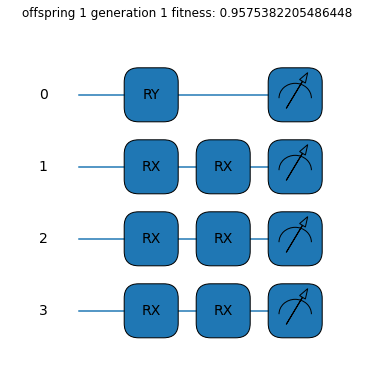

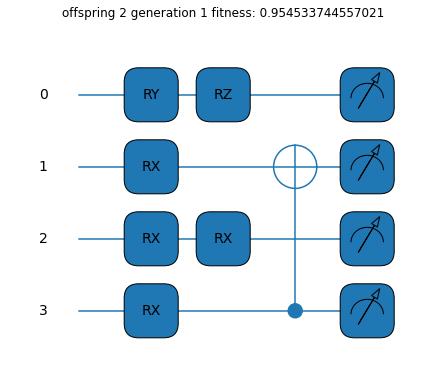

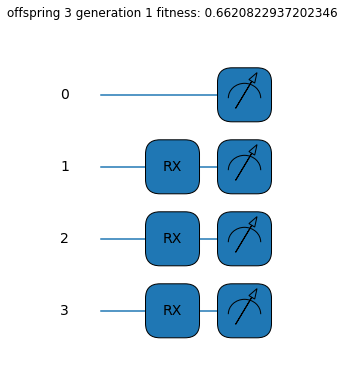

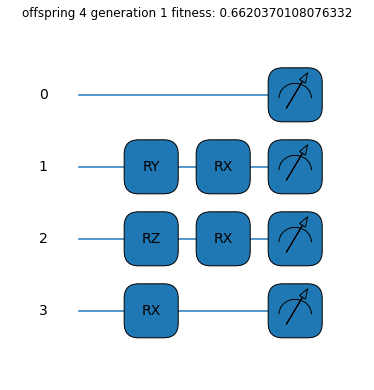

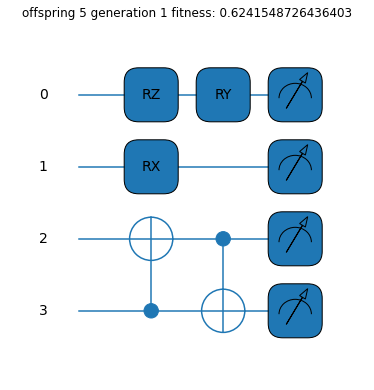

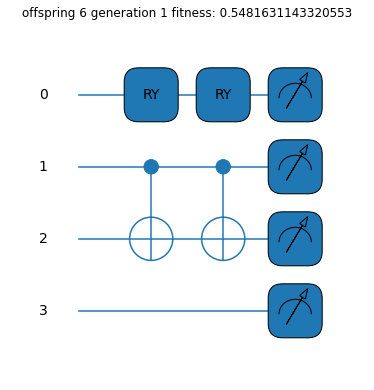

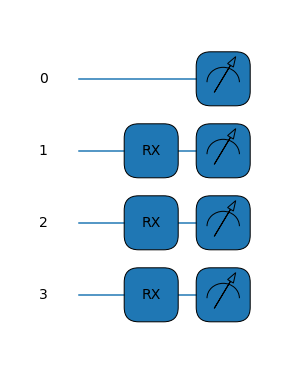

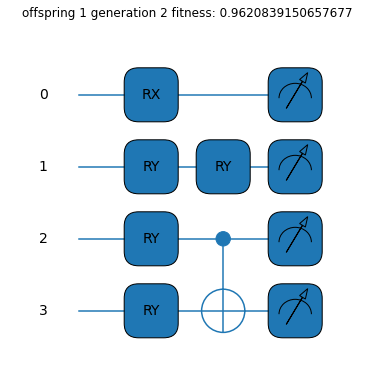

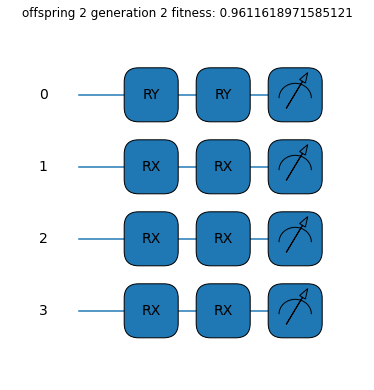

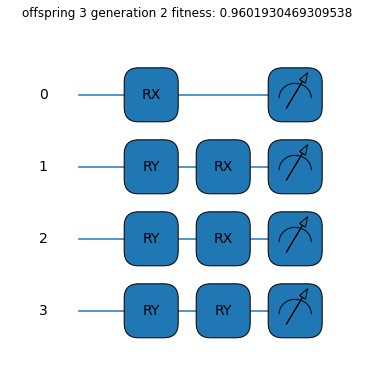

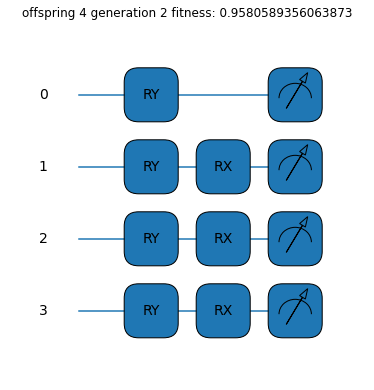

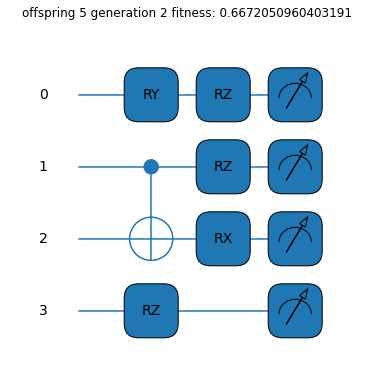

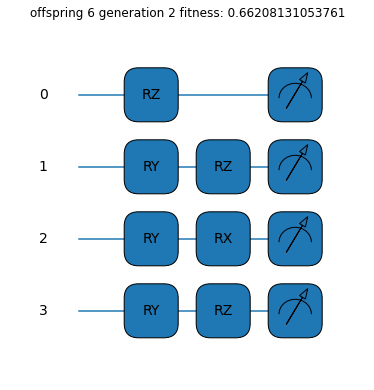

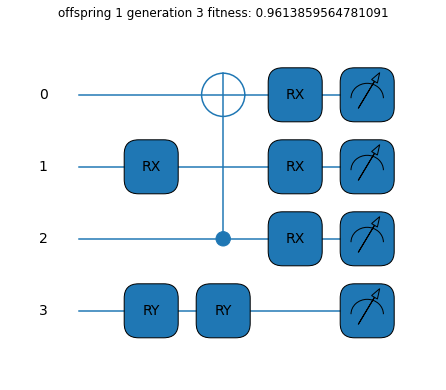

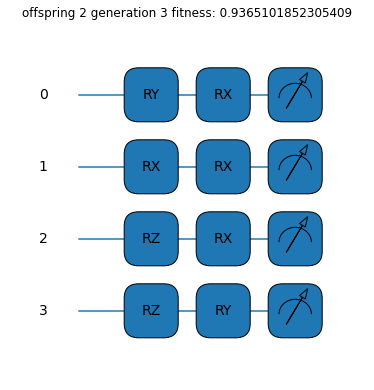

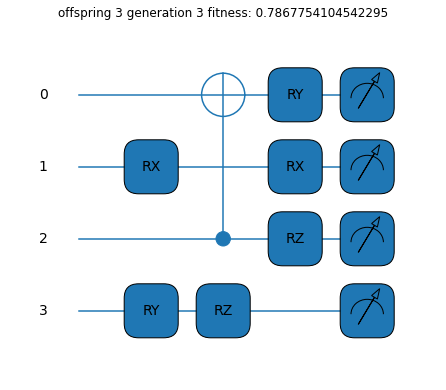

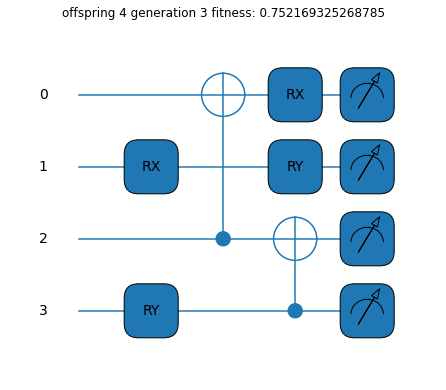

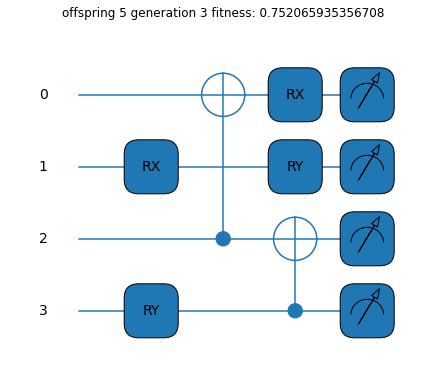

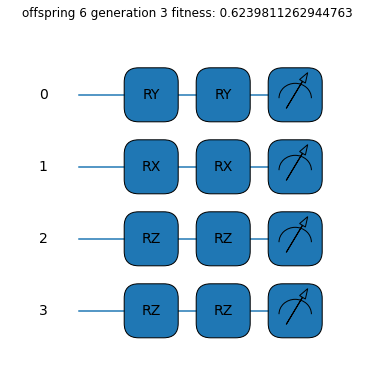

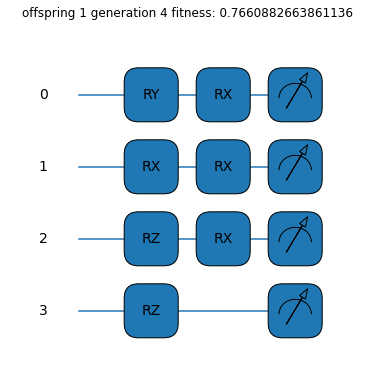

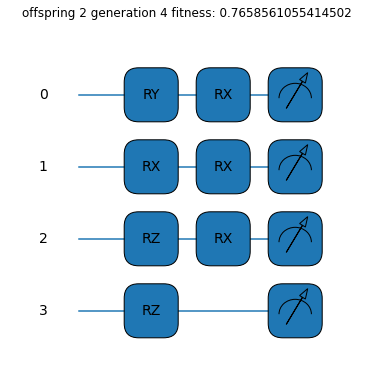

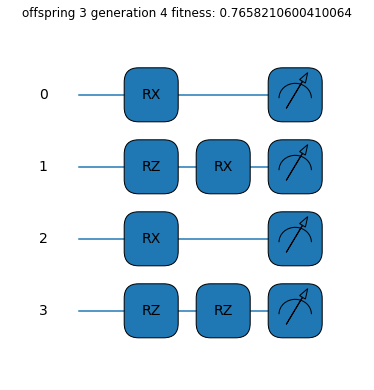

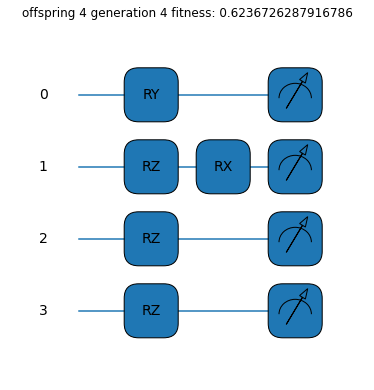

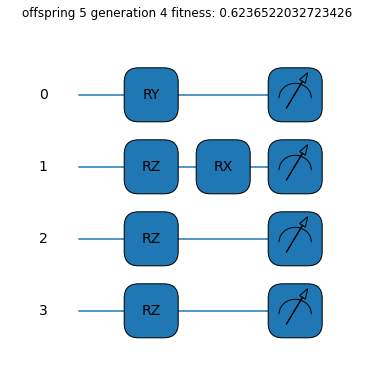

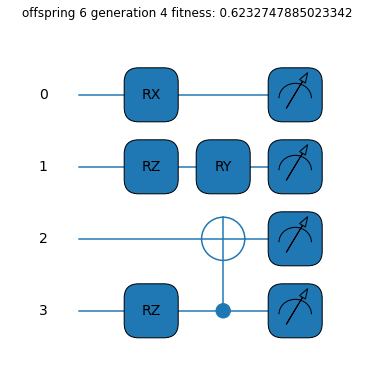

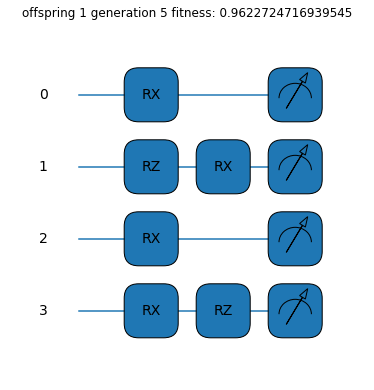

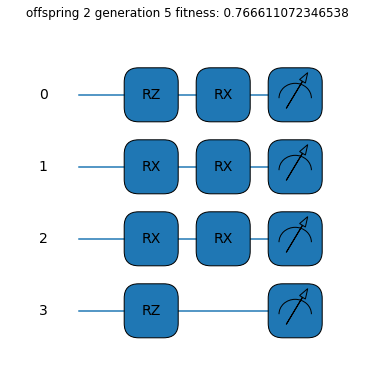

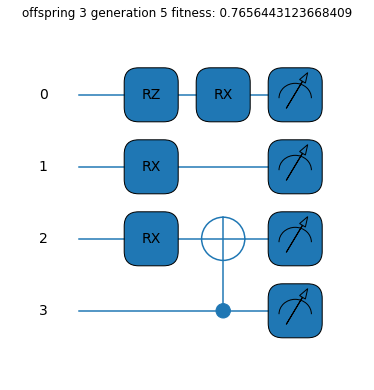

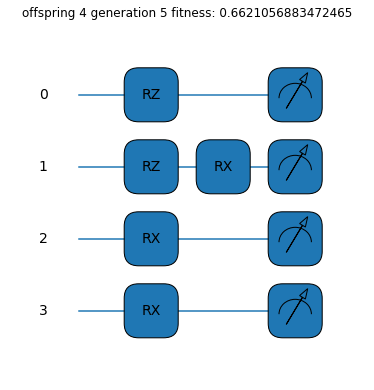

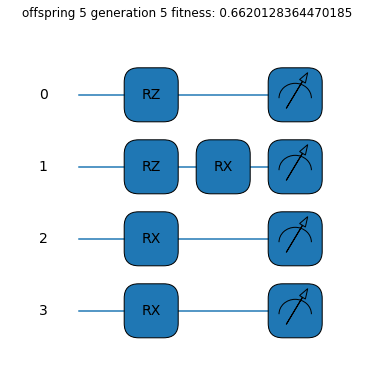

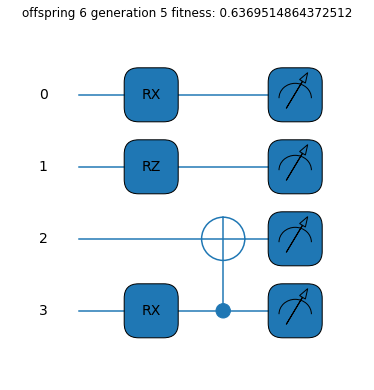

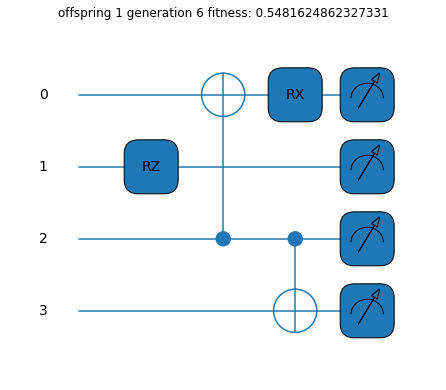

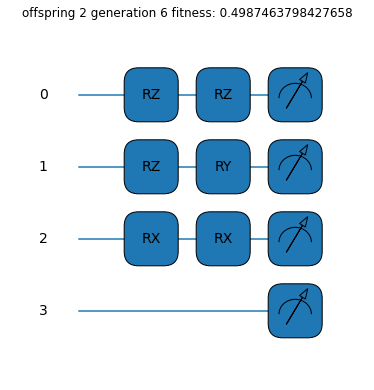

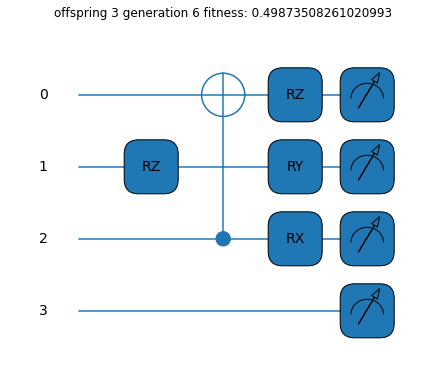

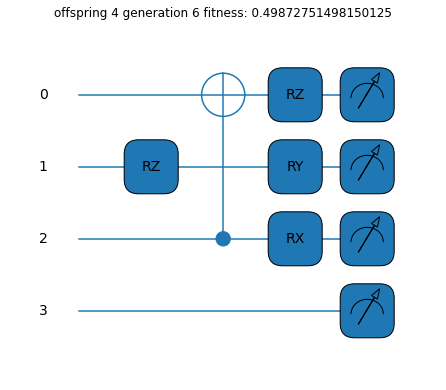

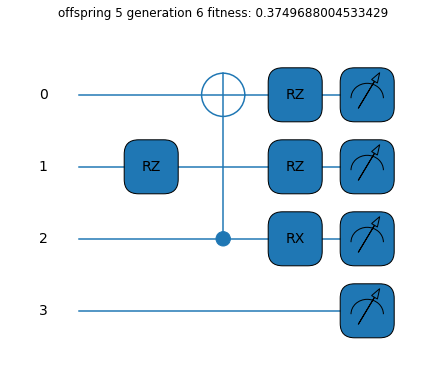

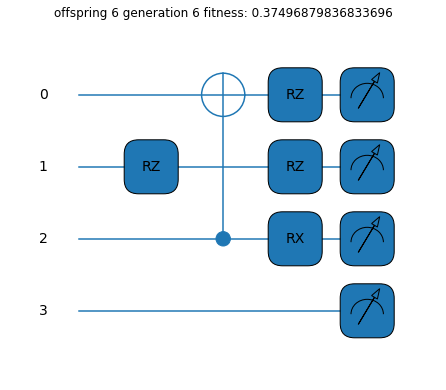

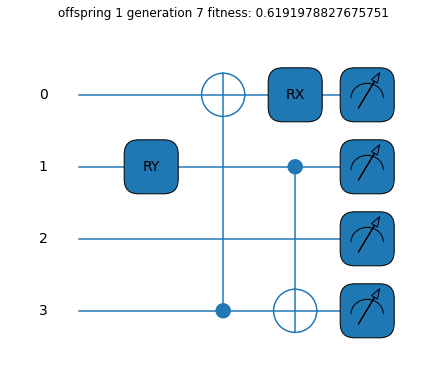

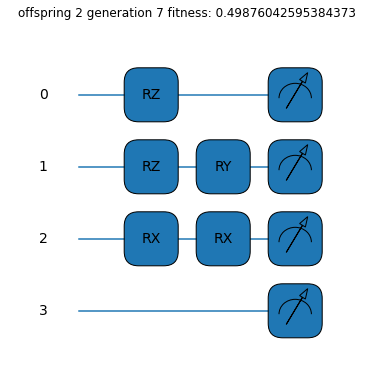

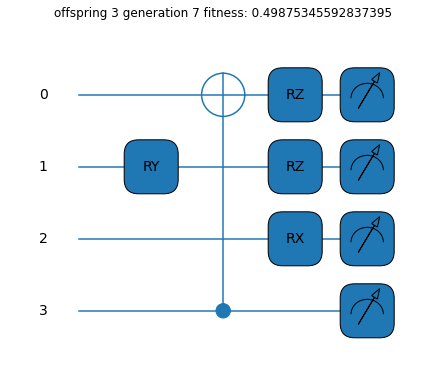

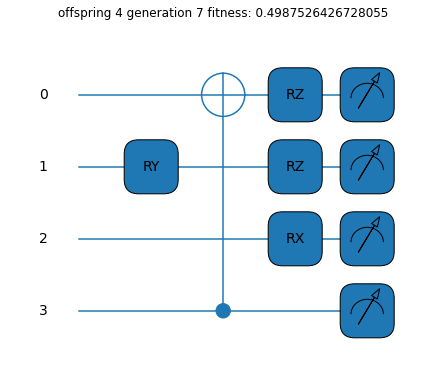

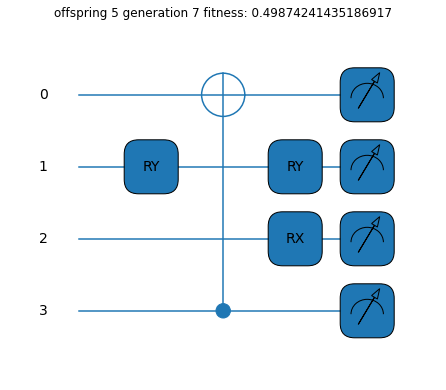

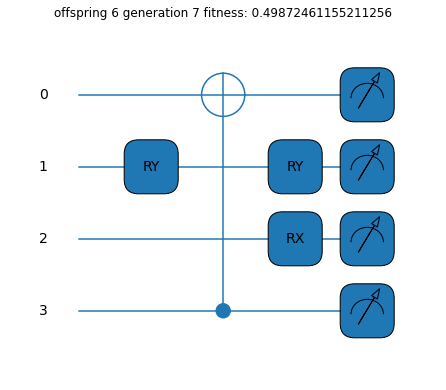

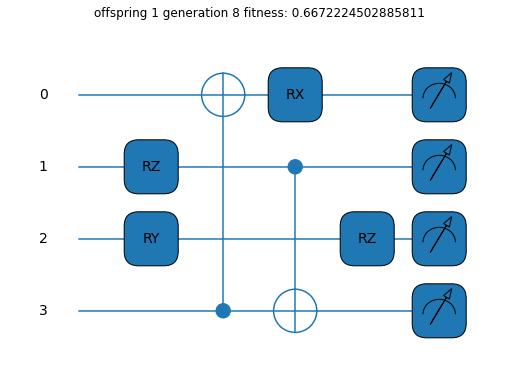

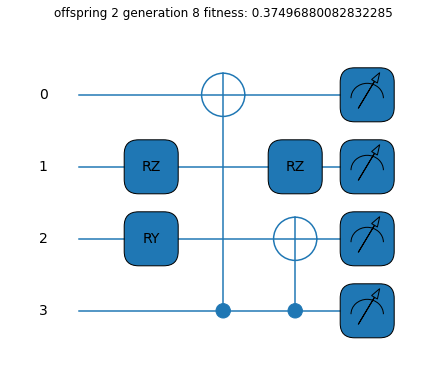

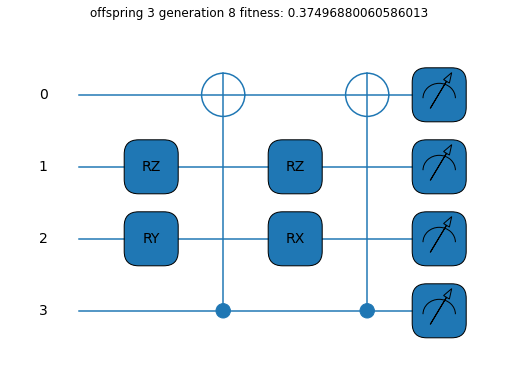

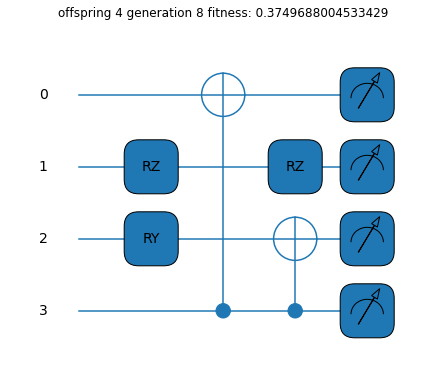

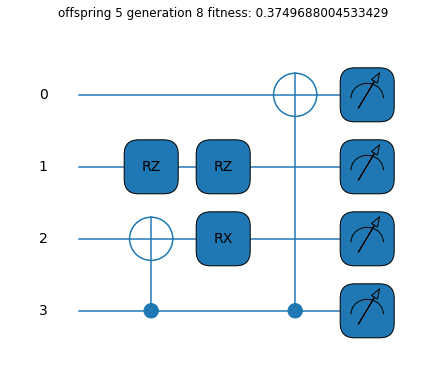

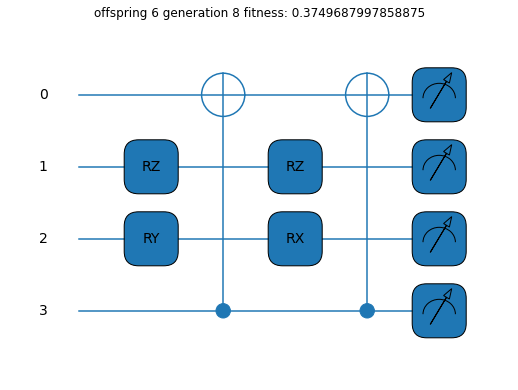

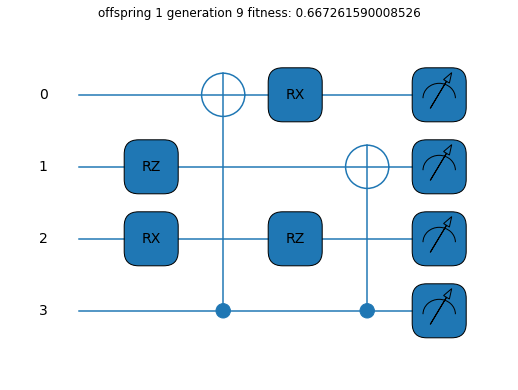

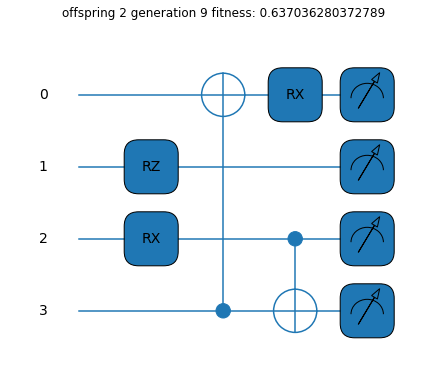

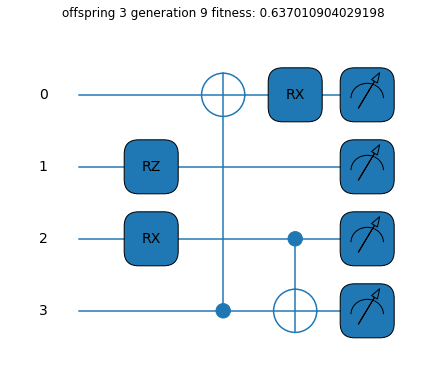

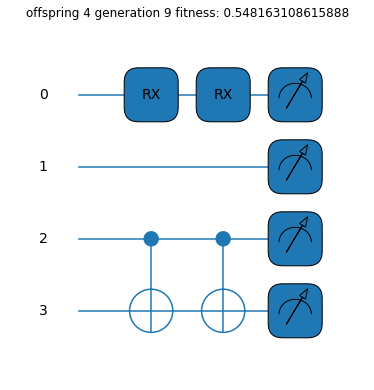

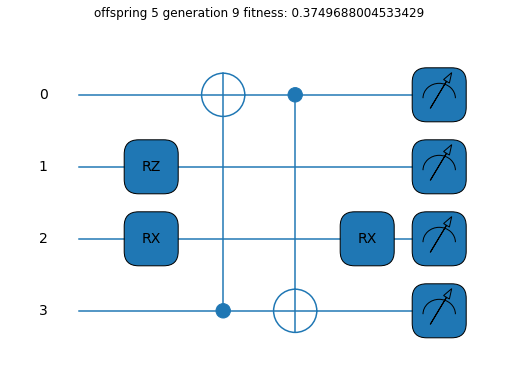

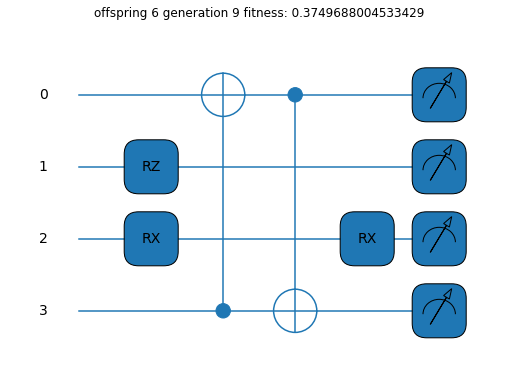

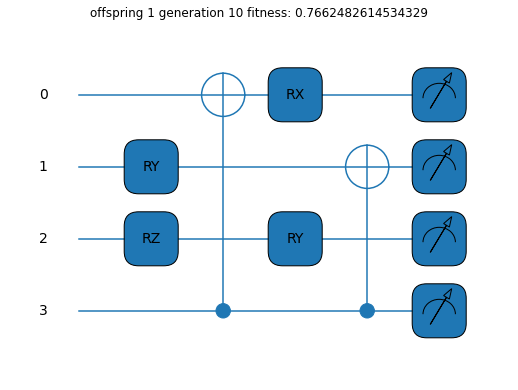

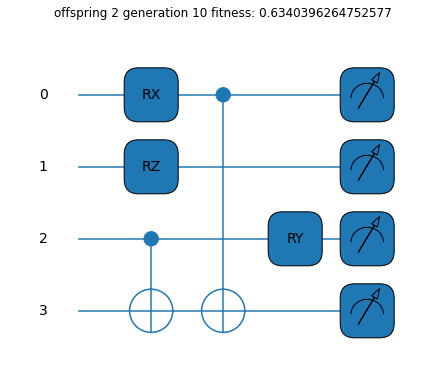

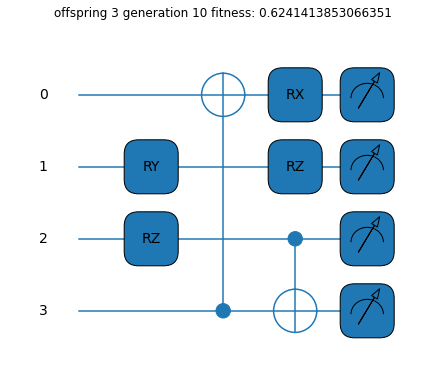

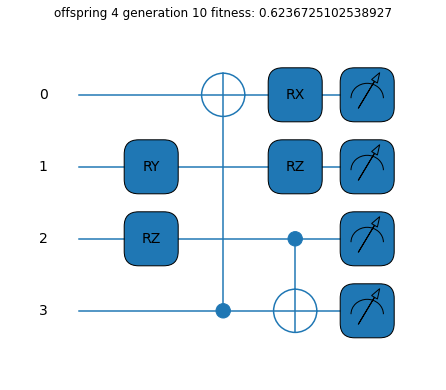

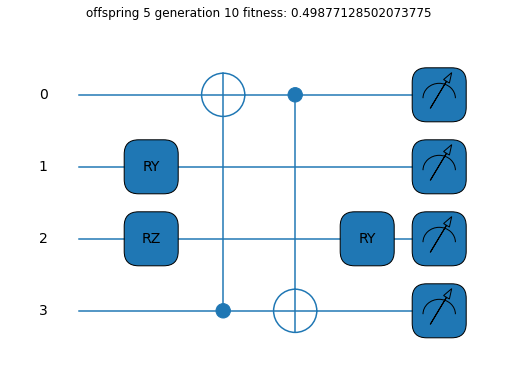

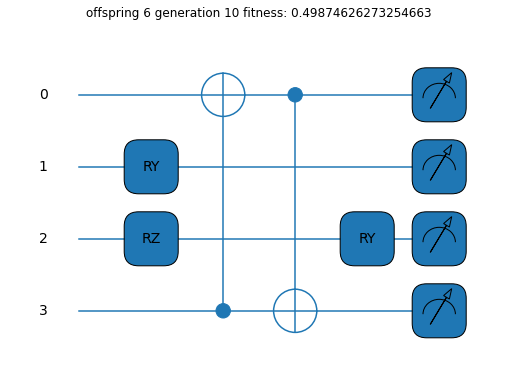

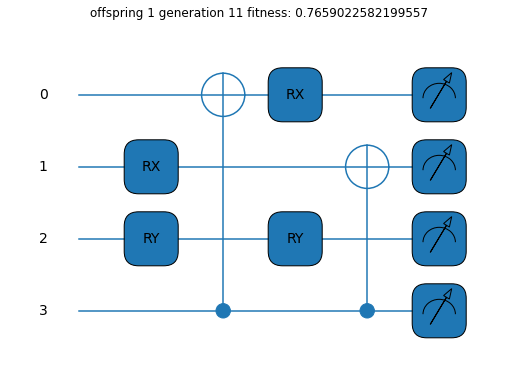

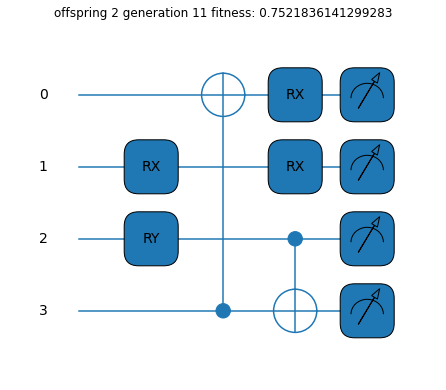

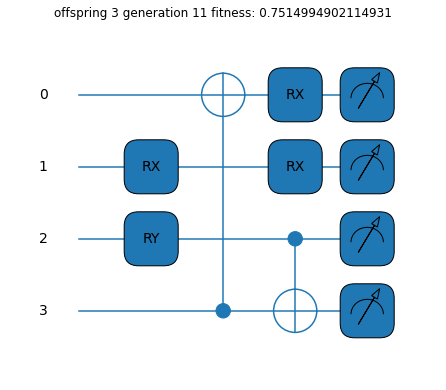

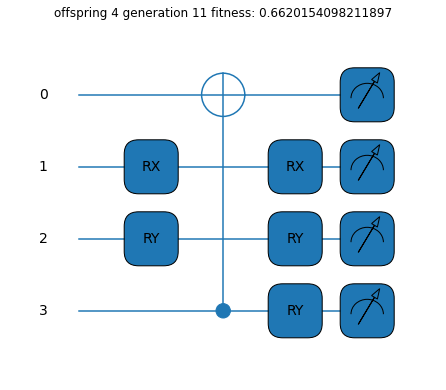

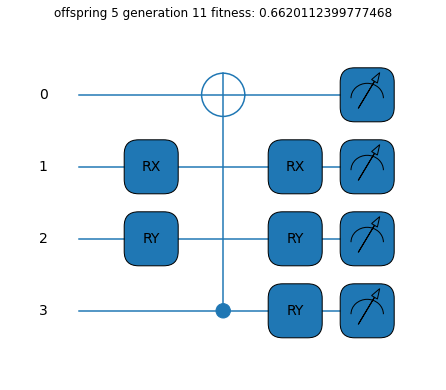

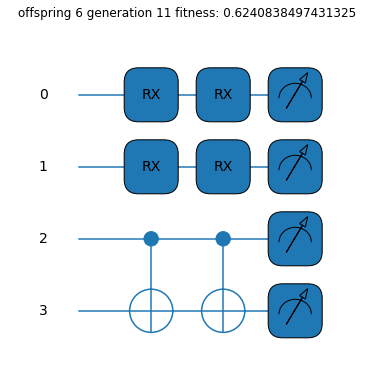

In [26]:
pop_size = 20
opt1 = CircuitOptimizer(pop_size, probability_pt, num_one_gates, num_two_gates, max_moments, n_qubits)
curr_max_fitness = opt1.population.fittest.get_fitness()
overall_max_fitness = curr_max_fitness
patience = 5

unchanged_num_gens = 0
while unchanged_num_gens <= patience:
    opt1.generation += 1
    opt1.selection()
    opt1.crossover()
    
    for i in range(4):
        if random.random() < 0.7:
            opt1.mutate()
            
    opt1.train_offsprings()
    opt1.draw_offsprings()
    opt1.print_info()

    opt1.add_offsprings()
    
    curr_max_fitness = opt1.population.fittest.get_fitness()
    if curr_max_fitness > overall_max_fitness:
        overall_max_fitness = curr_max_fitness
        unchanged_num_gens = 0
    else:
        unchanged_num_gens +=1

In [ ]:
for i in range(len(opt1.offsprings.individuals)):
    curr_offspring = opt1.offsprings.individuals[i]
    print(curr_offspring.tensor)